In [93]:
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer

warnings.filterwarnings('ignore')

In [30]:
movies_df = pd.read_csv('movies_metadata.csv')
movies_df = movies_df[['id','original_title','genres','original_language','vote_average']]

In [31]:
def get_genres(genre_list):
    return ' '.join([item['name'] for item in eval(genre_list)])

In [32]:
movies_df['genres'] = movies_df['genres'].apply(lambda x : get_genres(x))

In [33]:
movies_df.head(2)

,id,original_title,genres,original_language,vote_average
0,862,Toy Story,Animation Comedy Family,en,7.7
1,8844,Jumanji,Adventure Fantasy Family,en,6.9


In [62]:
scaler  = MinMaxScaler()
movies_df['average_vote_scaled'] = scaler.fit_transform(movies_df[['vote_average']])

### NORMAL MOVIE RECOMMENDATION SYSTEM

MOVIE IS RECOMMENDED BASED ON SIMILARITIES IN GENRE

In [63]:
vectorizer = CountVectorizer()
genre_matrix = vectorizer.fit_transform(movies_df['genres'])

In [88]:
def recommend_movies(selected_movie_id, movies_df, genre_matrix, top_n=5):
    
    selected_movie_index = movies_df.index[movies_df['id'] == str(selected_movie_id)][0]



    cosine_similarities = cosine_similarity(genre_matrix[selected_movie_index], genre_matrix).flatten()
    
    
    similar_indices = cosine_similarities.argsort()[::-1][1:top_n+1]
    
    
    recommended_movies = movies_df.iloc[similar_indices][['original_title', 'average_vote_scaled', 'genres']]
    
    return recommended_movies

In [79]:
selected_movie_id = 862
recommendations = recommend_movies(selected_movie_id, movies_df, genre_matrix, top_n=5)

In [89]:
for movie in recommendations['original_title'].values:
    print(movie,end='\n')

Leroy & Stitch
The Flintstones & WWE: Stone Age Smackdown
Scooby-Doo Goes Hollywood
Big Top Scooby-Doo!
Scooby-Doo! and the Loch Ness Monster


### FORMULATING MAB FOR THE ABOVE RECOMMENDATION SYSTEM

ARM - MOVIES

EXPECTED  - LETS HAVE THE AVERAGE VOTING SCALED AS THE REWARD (ASSUMOTIONS SAKE)

ACTION -SELECTING ONE OF THE MOVIES OF PROBABILITY EPSILON FOR EXPLOITATION AND 1-EPSILON FOR EXPLORATION

INSTEAD OF CHOOSING RANDOM NUMBER BETWEEN 0 AND 1 TO COMPARE WITH EPSILON VALUE TO CHOOSE EXPLOITATION OR EXPLORATION, LETS TAKE THAT VALUE AS THE SIMILARITY SCORE INSTEAD, AS IT MAKES MORE SENSE SINCE WE ARE RECOMMENDING BASED ON GENRE.

FOR CHOOSINF THE CORRECT OPTIONS LETS REWARD IT A +0.5 TO THE AVERAGE VOTING SCORE AND -0.2 FOR NOT CHOOSING THE BEST OPTION.

In [173]:
epsilon = 0.2
reward_boost = 0.5
num_iterations = 500

In [185]:
#testung out mab for a very small subset of the origial dataset

movies_df_copy  = movies_df.iloc[:6,:]  


In [175]:
selected_movie_ids = movies_df_copy['id'].tolist()
movie_rewards = {movie_id: round(movies_df_copy.loc[movies_df_copy['id'] == movie_id, 'average_vote_scaled'].values[0],2) for movie_id in selected_movie_ids}
movie_counts = {movie_id: 0 for movie_id in selected_movie_ids}

In [176]:
movie_rewards

{'862': 0.77,
 '8844': 0.69,
 '15602': 0.65,
 '31357': 0.61,
 '11862': 0.57,
 '949': 0.77}

In [177]:
movie_counts

{'862': 0, '8844': 0, '15602': 0, '31357': 0, '11862': 0, '949': 0}

In [178]:
def user_engagement():
    return np.random.rand() > 0.5 

In [179]:
reward_history = {movie_id: [] for movie_id in selected_movie_ids}

In [180]:
reward_history

{'862': [], '8844': [], '15602': [], '31357': [], '11862': [], '949': []}

In [181]:
vectorizer = CountVectorizer()
genre_matrix = vectorizer.fit_transform(movies_df_copy['genres'])

In [182]:
current_movie_index = np.random.choice(selected_movie_ids)

for i in range(num_iterations):
   
    selected_movie_index = current_movie_index
    
    
    selected_movie_index = movies_df_copy.index[movies_df_copy['id'] == selected_movie_index][0]

   
    cosine_similarities = cosine_similarity(genre_matrix[selected_movie_index], genre_matrix).flatten()
    
    selected_similarities = {movie_id: cosine_similarities[movies_df_copy.index[movies_df_copy['id'] == movie_id][0]] for movie_id in selected_movie_ids}
    
    top_3_similar_movies = sorted(selected_similarities, key=selected_similarities.get, reverse=True)[:3]
    average_top_3_similarity = np.mean([selected_similarities[movie_id] for movie_id in top_3_similar_movies])

    
    if average_top_3_similarity > epsilon:
        best_movie_id = np.random.choice(top_3_similar_movies)
    else:
        best_movie_id = np.random.choice(selected_movie_ids)
    
    if user_engagement():  
        movie_rewards[best_movie_id] += reward_boost
    # else:
    #     movie_rewards[best_movie_id] -=0.2
    movie_counts[best_movie_id] += 1

    for movie_id in selected_movie_ids:
        reward_history[movie_id].append(movie_rewards[movie_id])



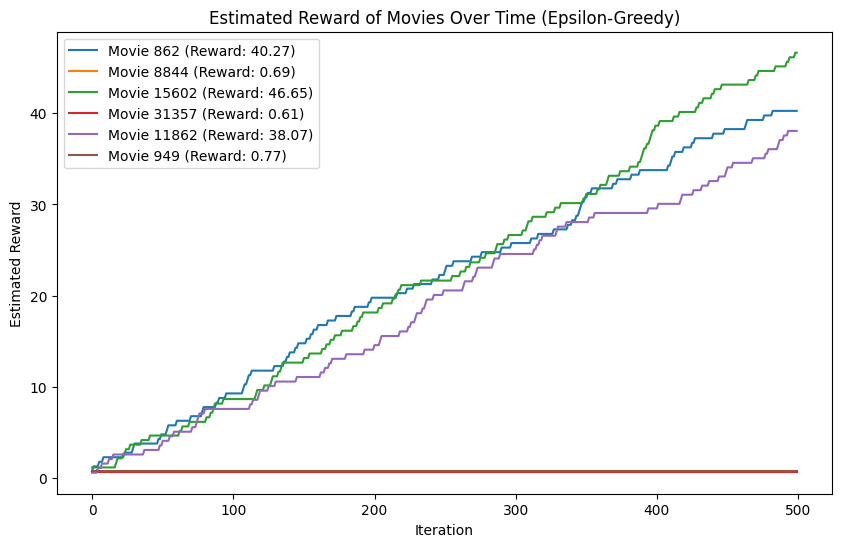

In [184]:
# Plotting the expected reward over time for each movie
plt.figure(figsize=(10, 6))
for movie_id, rewards in reward_history.items():
    # print(len(rewards))
    # print(rewards)
    plt.plot(range(num_iterations), rewards, label=f"Movie {movie_id} (Reward: {movie_rewards[movie_id]:.2f})")

plt.xlabel('Iteration')
plt.ylabel('Estimated Reward')
plt.title('Estimated Reward of Movies Over Time (Epsilon-Greedy)')
plt.legend()
plt.show()